In [ ]:
# Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import norm
import plotly.express as px
import statsmodels.formula.api as smf
from sklearn.linear_model import HuberRegressor
plt.style.use('ggplot')

In [ ]:
# Create the data frame

path = r'/content/hiatus.csv' # Get the file path from your local machine
raw_data = pd.read_csv(path)
df = pd.read_csv(path).drop(columns=['End Date']) # The Unnamed: 0 column may not
# be in your data frame, comment out or remove if this is the case
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['Click Through Rate'] = df['Clicks'] / df['Impressions']
df = df.set_index('Start Date')[['Spend','Click Through Rate','Network', 'Revenue']].fillna(0)
sm1 = df[df['Network'] == 'Social Media 1'].drop(columns='Network')
sm2 = df[df['Network'] == 'Social Media 2'].drop(columns='Network')
sm3 = df[df['Network'] == 'Social Media 3'].drop(columns='Network')
search = df[df['Network'] == 'Search'].drop(columns='Network')

In [ ]:
# List outliers and other anomalies

print('Significant at p < 0.05: \n\n')
outliers = df[df['Revenue'] > df['Revenue'].mean() + 3*df['Revenue'].std()]
outliers['Spend Z-Score'] = (outliers['Spend'] - df['Spend'].mean()) / df['Spend'].std()
outliers['Click Through Rate Z-Score'] = (outliers['Click Through Rate'] - df['Click Through Rate'].mean()) / df['Click Through Rate'].std()
outliers['Revenue Z-Score'] = (outliers['Revenue'] - df['Revenue'].mean()) / df['Revenue'].std()
outliers['Spend p-value'] = norm.sf(outliers['Spend Z-Score'])
outliers['Click Through Rate p-value'] = norm.sf(outliers['Click Through Rate Z-Score'])
outliers['Revenue p-value'] = norm.sf(outliers['Revenue Z-Score'])
outliers = outliers[['Network','Spend','Spend Z-Score','Spend p-value','Click Through Rate', 'Click Through Rate Z-Score',
                     'Click Through Rate p-value', 'Revenue','Revenue Z-Score', 'Revenue p-value']]
outliers

In [ ]:
# Turn Network into a categorical variable

df = df[df['Revenue'] <= df['Revenue'].mean()+3*df['Revenue'].std()] # Remove anomalies
sm1 = df[df['Network'] == 'Social Media 1'].drop(columns='Network')
sm2 = df[df['Network'] == 'Social Media 2'].drop(columns='Network')
sm3 = df[df['Network'] == 'Social Media 3'].drop(columns='Network')
search = df[df['Network'] == 'Search'].drop(columns='Network')
get_dumms = pd.get_dummies(df['Network'])
frames = [df.drop(columns=['Network','Revenue']),get_dumms]
perc_removed = len(df[df['Revenue'] > df['Revenue'].mean()+3*df['Revenue'].std()]) / len(df) * 100
print('Percent of data removed:', str('{0:.2f}'.format(perc_removed))+'%')

Percent of data removed: 1.43%


In [ ]:
# Create new preprocessed data frame

preprocessed = pd.concat(frames,axis=1)
preprocessed['Revenue'] = df['Revenue']

In [ ]:
# Split dependent and independent variables

X = preprocessed.drop(columns='Revenue')
y = preprocessed['Revenue']

In [ ]:
# Find the best split for the mean squared error

splits = []

for i in range(1,10):
  splits.append(train_test_split(X, y, test_size=i/10, random_state=42))

In [ ]:
# Create lists for the training and testing data

X_TRAIN = []
X_TEST = []
y_TRAIN = []
y_TEST = []

for i in range(0,9):
  X_TRAIN.append(splits[i][0])
  X_TEST.append(splits[i][1])
  y_TRAIN.append(splits[i][2])
  y_TEST.append(splits[i][3])

In [ ]:
# Perform Huber regression on each split

HR = []

for i in range(0,9):
  HR.append(HuberRegressor().fit(X_TRAIN[i],y_TRAIN[i]))

In [ ]:
# Get predictions

Y_HAT = []

for i in range(0,9):
    Y_HAT.append(HR[i].predict(X_TEST[i]))

In [ ]:
# Get the mean squared errors

MSE = []

for i in range(0,9):
  MSE.append(mean_squared_error(y_TEST[i],Y_HAT[i]))

In [ ]:
# Create a dataframe for the error terms

errors = []
size = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(len(MSE)):
    err_dict = {'Test Size' : size[i],
                'MSE' : MSE[i]}
    errors.append(err_dict)
error_df = pd.DataFrame(errors)

Minimum MSE:  601862310.730497
Test Size:  0.7 



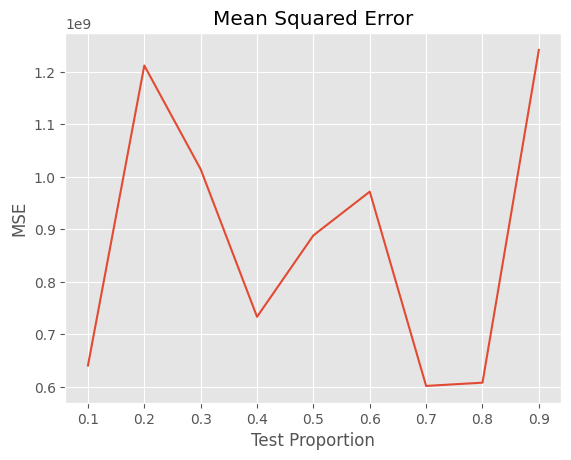

In [ ]:
# Plot the MSE by test size

size = error_df.sort_values(by='MSE').iloc[0][0]
min_err = error_df.sort_values(by='MSE').iloc[0][1]
print('Minimum MSE: ', min_err)
print('Test Size: ', size,'\n')
plt.plot(error_df['Test Size'],error_df['MSE'])
plt.xlabel('Test Proportion')
plt.ylabel('MSE')
plt.title('Mean Squared Error')
plt.show()

In [ ]:
# Create the model and fit to the training data

huber = HuberRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
huber.fit(X_train,y_train)

HuberRegressor()

In [ ]:
# Get model results

sm1_score = r2_score(sm1['Revenue'],huber.predict(preprocessed[preprocessed['Social Media 1']==1].drop(columns=['Revenue'])))
sm2_score = r2_score(sm2['Revenue'],huber.predict(preprocessed[preprocessed['Social Media 2']==1].drop(columns=['Revenue'])))
sm3_score = r2_score(sm3['Revenue'],huber.predict(preprocessed[preprocessed['Social Media 3']==1].drop(columns=['Revenue'])))
search_score = r2_score(search['Revenue'],huber.predict(preprocessed[preprocessed['Search']==1].drop(columns=['Revenue'])))
scores = ['*','*',search_score,sm1_score,sm2_score,sm3_score] # Scores on each channel according to the model
type_ = ['[0,inf)','[0,1]','{0,1}','{0,1}','{0,1}','{0,1}']
category = ['Numeric','Numeric', 'Categorical','Categorical', 'Categorical', 'Categorical']

huber_dict = []

for i in range(len(huber.coef_)):
  dictionary = {'Variable' : preprocessed.columns[:-1][i],
                'Type' : category[i],
                'Index (i)' : i+1,
                'Domain (Xi)' : type_[i],
                'Coefficient (βi)' : '{0:.2f}'.format(huber.coef_[i]),
                'R-Squared Score: ': scores[i]}
  huber_dict.append(dictionary)
huber_df = pd.DataFrame(huber_dict).set_index('Index (i)')

In [ ]:
# Summary Statistics for Social Media 1

print('Social Media 1 Summary Statistics: \n\n')
sm1_stats = sm1.describe().T
sm1_stats

Social Media 1 Summary Statistics: 




,count,mean,std,min,25%,50%,75%,max
Spend,52.0,69276.519231,26482.320908,22538.000000,51020.500000,69489.500000,78420.500000,146741.000000
Click Through Rate,52.0,0.011978,0.003041,0.004215,0.009768,0.011745,0.014673,0.018411
Revenue,52.0,105912.000000,52847.365760,13728.000000,66885.000000,108186.000000,136578.000000,259896.000000


In [ ]:
# Summary Statistics for Social Media 2

print('Social Media 2 Summary Statistics: \n\n')
sm2_stats = sm2.describe().T
sm2_stats

Social Media 2 Summary Statistics: 




,count,mean,std,min,25%,50%,75%,max
Spend,51.0,77207.509804,51436.877812,23032.000000,49667.000000,58575.000000,78695.500000,270228.000000
Click Through Rate,51.0,0.011252,0.001827,0.008059,0.010017,0.011069,0.012132,0.016126
Revenue,51.0,124312.941176,53305.442266,57750.000000,86212.500000,105765.000000,154357.500000,307395.000000


In [ ]:
# Summary Statistics for Social Media 3

print('Social Media 3 Summary Statistics: \n\n')
sm3_stats = sm3.describe().T
sm3_stats

Social Media 3 Summary Statistics: 




,count,mean,std,min,25%,50%,75%,max
Spend,56.0,36077.308571,54583.884460,0.0,5535.320000,14037.780000,39533.950000,274980.300000
Click Through Rate,56.0,0.006308,0.002209,0.0,0.005811,0.006673,0.007524,0.009873
Revenue,56.0,36147.321429,58664.471531,0.0,3712.500000,15075.000000,36225.000000,289500.000000


In [ ]:
# Summary Statistics for Search

print('Search Summary Statistics: \n\n')
search_stats = search.describe().T
search_stats

Search Summary Statistics: 




,count,mean,std,min,25%,50%,75%,max
Spend,51.0,33546.882353,14849.158695,11658.000000,21461.000000,33450.000000,43427.500000,82034.000000
Click Through Rate,51.0,0.080053,0.066923,0.038597,0.043498,0.059399,0.069447,0.318999
Revenue,51.0,67508.137255,45002.198856,14235.000000,37342.500000,60255.000000,85897.500000,297960.000000


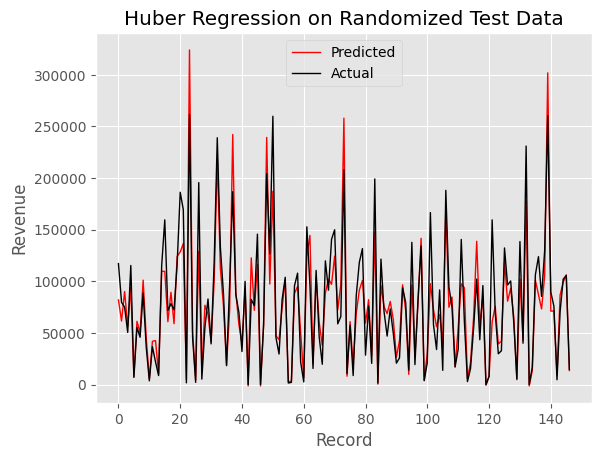

In [ ]:
# Plot results with randomized test data

plt.plot(huber.predict(X_test),color='r',label='Predicted', linewidth=1)
plt.title('Huber Regression on Randomized Test Data')
plt.plot(y_test.values,color='k', label='Actual', linewidth=1)
plt.legend()
plt.ylabel('Revenue')
plt.xlabel('Record')
plt.show()

In [ ]:
# Compare with the new Huber Regressor

yhat = np.array(huber.predict(X_test)).reshape(-1,1)
print('Huber Regression Results: \n\n')
print('Target (Y): ', 'Revenue')
print('Model: ', 'Huber Regressor')
print('R-Squared Score: ', huber.score(X_test,y_test))
print('Test Size: ', size)
print('Mean-Squared Error: ', min_err)
print('Bias (β0): ', huber.intercept_) # Number added to the model
print('Scale: ', huber.scale_)
print('Parameters: ', huber.get_params(),'\n')
huber_df

Huber Regression Results: 


Target (Y):  Revenue
Model:  Huber Regressor
R-Squared Score:  0.8402630771805806
Test Size:  0.7
Mean-Squared Error:  601862310.730497
Bias (β0):  13087.678733001265
Scale:  9444.008181731271
Parameters:  {'alpha': 0.0001, 'epsilon': 1.35, 'fit_intercept': True, 'max_iter': 100, 'tol': 1e-05, 'warm_start': False} 



,Variable,Type,Domain (Xi),Coefficient (βi),R-Squared Score:
Index (i),,,,,
1,Spend,Numeric,"[0,inf)",1.18,*
2,Click Through Rate,Numeric,"[0,1]",389.07,*
3,Search,Categorical,"{0,1}",7484.43,0.258802
4,Social Media 1,Categorical,"{0,1}",409.96,0.684478
5,Social Media 2,Categorical,"{0,1}",17778.01,0.776334
6,Social Media 3,Categorical,"{0,1}",-14425.16,0.935177


In [ ]:
# Create proportions based on the coefficients

allocation = []
total = 0
my_list = list(huber.coef_[2:6])
for i in my_list:
  if i<0:
    my_list.remove(i)
    my_list.append(0)
for i in my_list:
  total += i
for j in my_list:
  new = j/total
  allocation.append(new)

In [ ]:
# Create dataframe for percent spread

channel = ['Search', 'Social Media 1', 'Social Media 2', 'Social Media 3']
allocation_data = []

for i in range(len(channel)):
  alloc_dict = {'Channel' : channel[i],
                'Percent Spread' : str("{:.2f}".format(allocation[i]*100))+'%'}
  allocation_data.append(alloc_dict)
allocation_df = pd.DataFrame(allocation_data).set_index('Channel')
allocation_df.loc['Social Media 3'][0] = '<1%'
allocation_df

,Percent Spread
Channel,
Search,29.15%
Social Media 1,1.60%
Social Media 2,69.25%
Social Media 3,<1%


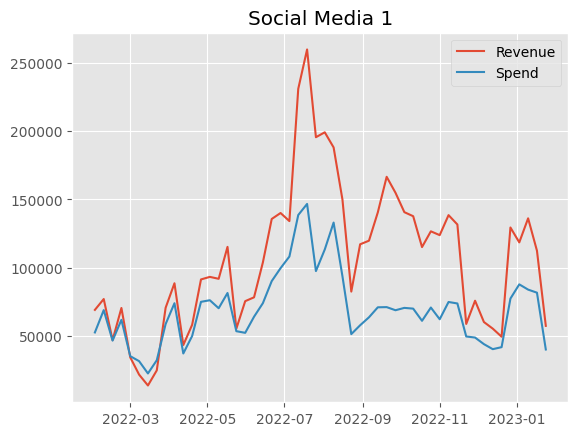

In [ ]:
plt.plot(sm1['Revenue'], label='Revenue')
plt.plot(sm1['Spend'], label='Spend')
plt.title('Social Media 1')
plt.legend()
plt.show()

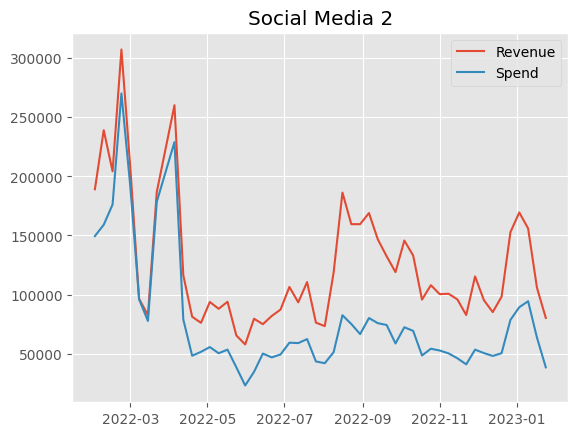

In [ ]:
plt.plot(sm2['Revenue'], label='Revenue')
plt.plot(sm2['Spend'], label='Spend')
plt.title('Social Media 2')
plt.legend()
plt.show()

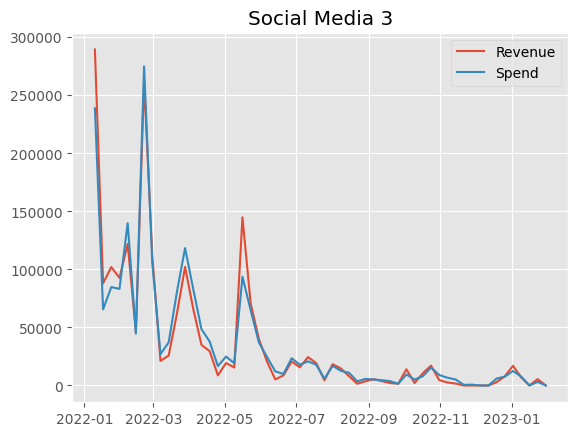

In [ ]:
plt.plot(sm3['Revenue'], label='Revenue')
plt.plot(sm3['Spend'], label='Spend')
plt.title('Social Media 3')
plt.legend()
plt.show()

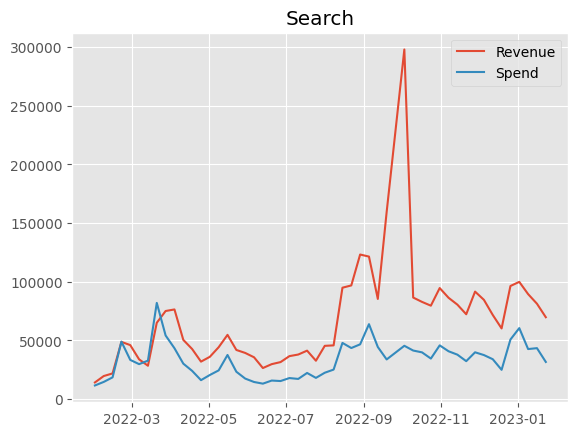

In [ ]:
plt.plot(search['Revenue'], label='Revenue')
plt.plot(search['Spend'], label='Spend')
plt.title('Search')
plt.legend()
plt.show()

In [ ]:
px.line(df.groupby('Start Date')['Spend','Revenue'].sum(), title='Aggregate Data')

<ipython-input-28-ee9e8b96cb60>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  px.line(df.groupby('Start Date')['Spend','Revenue'].sum(), title='Aggregate Data')


In [ ]:
huber_df

,Variable,Type,Domain (Xi),Coefficient (βi),R-Squared Score:
Index (i),,,,,
1,Spend,Numeric,"[0,inf)",1.18,*
2,Click Through Rate,Numeric,"[0,1]",389.07,*
3,Search,Categorical,"{0,1}",7484.43,0.258802
4,Social Media 1,Categorical,"{0,1}",409.96,0.684478
5,Social Media 2,Categorical,"{0,1}",17778.01,0.776334
6,Social Media 3,Categorical,"{0,1}",-14425.16,0.935177


In [ ]:
# Make coeffiecients interpretable, determine the magnitude of each platform on $0.18 return.

coefs = huber_df['Coefficient (βi)'][1:].astype('float').values
coefs[-1] = abs(coefs[-1])
coef_sum = coefs.sum()
cents = float(huber_df['Coefficient (βi)'][1]) - 1
freq = ((coefs / coef_sum) * cents)[1:]
rel_freq = (coefs / coef_sum) * cents
pop = rel_freq[0]
rel_freq = rel_freq[1:]
sol = rel_freq * pop
solution = (freq + sol)[:-1]

In [ ]:
# Store new dataframe

solution_df = pd.DataFrame()
solution_df['Channel'] = ['Search', 'Social Media 1', 'Social Media 2']
solution_df['Contribution'] = solution
solution_df = solution_df.set_index('Channel')
solution_df

,Contribution
Channel,
Search,0.033333
Social Media 1,0.001826
Social Media 2,0.079176


In [ ]:
# Overall return on the dollar when SM3 has zero spend

cont = round(solution_df['Contribution'].sum(),2)
cont

0.11